In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings

from itertools import cycle

In [2]:
project_dir_path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/"
temp_files_path = project_dir_path+'TempFiles/'


# Load In Data

In [3]:
import pickle

save_path = temp_files_path
file_name = 'traintest_data2.pkl'

with open(save_path+file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols, SCALER, y_mean,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET


print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)

X_train:  torch.Size([4010, 17])
X_test:  torch.Size([398, 17])
period_train:  torch.Size([4010, 1089])
period_test:  torch.Size([398, 1089])
y_train:  torch.Size([4010, 1])
y_test:  torch.Size([398, 1])
feature_cols:  ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio', 'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']


In [4]:
# Full histogram illustrating the data:
import sys
sys.path.append(project_dir_path+'HelperFcns/')


from VisualizeDataset import visualize_feature_distributions, visualize_mass_bin_distribution
from VisualizeDataset import visualize_summary_stats, plot_correlation_matrix

visualize=False
if visualize:
    #visualize_feature_distributions(X_train, feature_cols)
    visualize_mass_bin_distribution(y_train, y_test)
    visualize_summary_stats(X_train, y_train, feature_cols)
    plot_correlation_matrix(X_train, feature_names=feature_cols, figsize=(14, 11), annot=True)
    #plot_correlation_matrix(period_train, feature_names=None, figsize=(14, 11), annot=False)


# Define The NN Model

In [5]:
# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN

# Load in all the training functions and helper functions

In [21]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Import training functions from helper file
import sys
sys.path.append(project_dir_path)

from Training_HelperFcns import (
    GaussianNLLLoss_ME, 
    sanitize_batch,
    Run_Single_Batch, 
    Run_Single_Epoch, 
    Train_Model,
    log_model_progress,
    plot_run_log
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in best model params

In [7]:
# ============================================================
# LOAD BEST MODEL PARAMETERS
# ============================================================

import pickle

# Load the best parameters exported from 1_HyperparamTuning.ipynb
load_path = temp_files_path + 'best_model_params.pkl'

with open(load_path, 'rb') as f:
    best_config = pickle.load(f)

# Extract the parameters
best_params = best_config['params']
best_epoch = best_config['best_epoch']

# Display what was loaded
print("="*70)
print("LOADED BEST MODEL CONFIGURATION")
print("="*70)
print(f"Model Name:      {best_config['model_name']}")
print(f"Run ID:          {best_config['run_id']}")
print(f"Composite Score: {best_config['composite_score']:.4f}")
print(f"Best Epoch:      {best_epoch}")

print(f"\nValidation Metrics @ Best Epoch:")
print(f"  Loss:          {best_config['metrics']['loss']:.4f}")
print(f"  Coverage@68%:  {best_config['metrics']['cov68']:.4f}")
print(f"  Coverage@95%:  {best_config['metrics']['cov95']:.4f}")
print(f"  {best_config['metrics']['err_metric1_name']}: {best_config['metrics']['err1']:.4f}")
print(f"  {best_config['metrics']['err_metric2_name']}: {best_config['metrics']['err2']:.4f}")

print(f"\nHyperparameters:")
for key, value in best_params.items():
    print(f"  {key:30s} = {value}")

print(f"\nRanking Info:")
print(f"  Total models evaluated: {best_config['ranking_info']['total_models_evaluated']}")
print(f"  Metric weights: {best_config['ranking_info']['metric_weights']}")
print("="*70)

LOADED BEST MODEL CONFIGURATION
Model Name:      Test_Model
Run ID:          5
Composite Score: 0.2915
Best Epoch:      16

Validation Metrics @ Best Epoch:
  Loss:          0.5157
  Coverage@68%:  0.6906
  Coverage@95%:  0.9404
  valid_median_sigma: 0.4585
  valid_MAE: 0.4458

Hyperparameters:
  Layer1_Size                    = 16
  Layer2_Size                    = 8
  artificial_loss_weight_factor  = 1
  batch_size                     = 20
  decoupled                      = False
  dropout_prob                   = 0.3
  learn_sigma                    = True
  lr                             = 0.003
  n_epochs                       = 75
  n_layers                       = 2
  num_kfolds                     = 7
  use_cnn                        = False
  use_periodogram                = True
  weight_decay                   = 1e-06

Ranking Info:
  Total models evaluated: 12
  Metric weights: {'loss': 0, 'cov68': 1, 'cov95': 1, 'err1': 0.3, 'err2': 0.3}


# Setup Data and Training Configuration

In [13]:
# ============================================================
# SETUP DATA AND TRAINING CONFIGURATION
# ============================================================

import time

# Define which datasets you wish to use
# Following same structure as K-fold training but for single model
summary_stat_dims = [X_train.shape[1]]
periodogram_dims = [period_train.shape[1]]

model_train_data_statistics  = [X_train]
model_train_data_periodogram = [period_train]
model_train_data_Y           = [y_train]

model_test_data_statistics   = [X_test]
model_test_data_periodogram  = [period_test]
model_test_data_Y            = [y_test]

model_names = ['Final_Best_Model']

# Initialize empty training log (same structure as K-fold)
empty_train_log = {
        "epoch" : [], 
        "mean_batch_loss" : [], 
        "train_errLoss" : [], 
        "train_sigmaLoss" : [], 
        "train_Loss" : [], 
        "train_MAE"  : [], 
        "train_RMSE" : [], 
        "train_median_sigma" : [], 
        "train_mean_sigma" : [], 
        "train_Coverage68" : [], 
        "train_Coverage95" : [], 
        "train_CRPS" : [], 
        "valid_errLoss" : [], 
        "valid_sigmaLoss" : [], 
        "valid_Loss" : [], 
        "valid_MAE"  : [], 
        "valid_RMSE" : [], 
        "valid_median_sigma" : [], 
        "valid_mean_sigma" : [], 
        "valid_Coverage68" : [], 
        "valid_Coverage95" : [], 
        "valid_CRPS" : [], 
}

# Create log structure (simpler - no K-fold, just one model)
final_model_log = {
    'params': best_params,
    'model': None,
    'log': copy.deepcopy(empty_train_log)
}

print("\n✅ Data and configuration setup complete")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Training on FULL training set (no K-fold)")


✅ Data and configuration setup complete
   Training samples: 4010
   Test samples: 398
   Training on FULL training set (no K-fold)


# Train Final Model on Full Training Set

In [14]:
# ============================================================
# TRAIN FINAL MODEL ON FULL TRAINING SET
# ============================================================

print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

for i, model_name in enumerate(model_names):    
    stats_dim = summary_stat_dims[i]
    period_dim = periodogram_dims[i]
    
    X_stats  = model_train_data_statistics[i]
    X_period = model_train_data_periodogram[i]
    Y        = model_train_data_Y[i]
    
    test_X_stats  = model_test_data_statistics[i]
    test_X_period = model_test_data_periodogram[i]
    test_Y        = model_test_data_Y[i]

    # Check for NaNs
    if torch.isnan(X_stats).any():
        print("⚠️ Warning: NaNs detected in X_train")
    
    if torch.isnan(test_X_stats).any():
        print("⚠️ Warning: NaNs detected in X_test")
    
    print(f"\nModel: {model_name}")
    print(f"Parameters: {best_params}")
    
    # Initialize model
    model_class = DualInputNN
    model_inputs = (
        stats_dim,
        period_dim,
        best_params['Layer1_Size'],
        best_params['dropout_prob'],
        best_params['use_periodogram'],
        best_params['use_cnn'],
        best_params['learn_sigma']
    )
    model = model_class(*model_inputs)
    
    # Prepare data (full training set, test set for validation monitoring)
    training_data = (X_stats, X_period, Y)
    validation_data = (test_X_stats, test_X_period, test_Y)
    
    # Train the model
    print(f"\n🚀 Starting training for {best_params['n_epochs']} epochs...")
    print(f"   Batch size: {best_params['batch_size']}")
    print(f"   Learning rate: {best_params['lr']}")
    print(f"   Dropout: {best_params['dropout_prob']}")
    
    training_log = final_model_log['log']
    model, final_model_log['log'], final_train_loss = Train_Model(
        model, 
        training_data, 
        validation_data, 
        best_params, 
        training_log
    )
    
    final_model_log['model'] = model
    
    print(f"\n✅ Training complete!")
    print(f"   Final training loss: {final_train_loss:.4f}")

print("="*70)


TRAINING FINAL MODEL

Model: Final_Best_Model
Parameters: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.003, 'n_epochs': 75, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}

🚀 Starting training for 75 epochs...
   Batch size: 20
   Learning rate: 0.003
   Dropout: 0.3
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 620.4309)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 772.2328)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1261.7725)
   Epoch 0, Loss: 1.80, Estimated Time Left: 0.71 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 254.6859)
   Epoch 5, Loss: 0.72, Estimated Time Left: 0.65 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 829.5394)
   Epoch 10, Loss: 0.60, Estimated Time Left: 0.60 min
   Epoch 15, Loss: 0.55, Estimated Time 

# Visualize Training Progress

In [24]:
final_model_log.keys()

dict_keys(['params', 'model', 'log'])


Generating training plots...


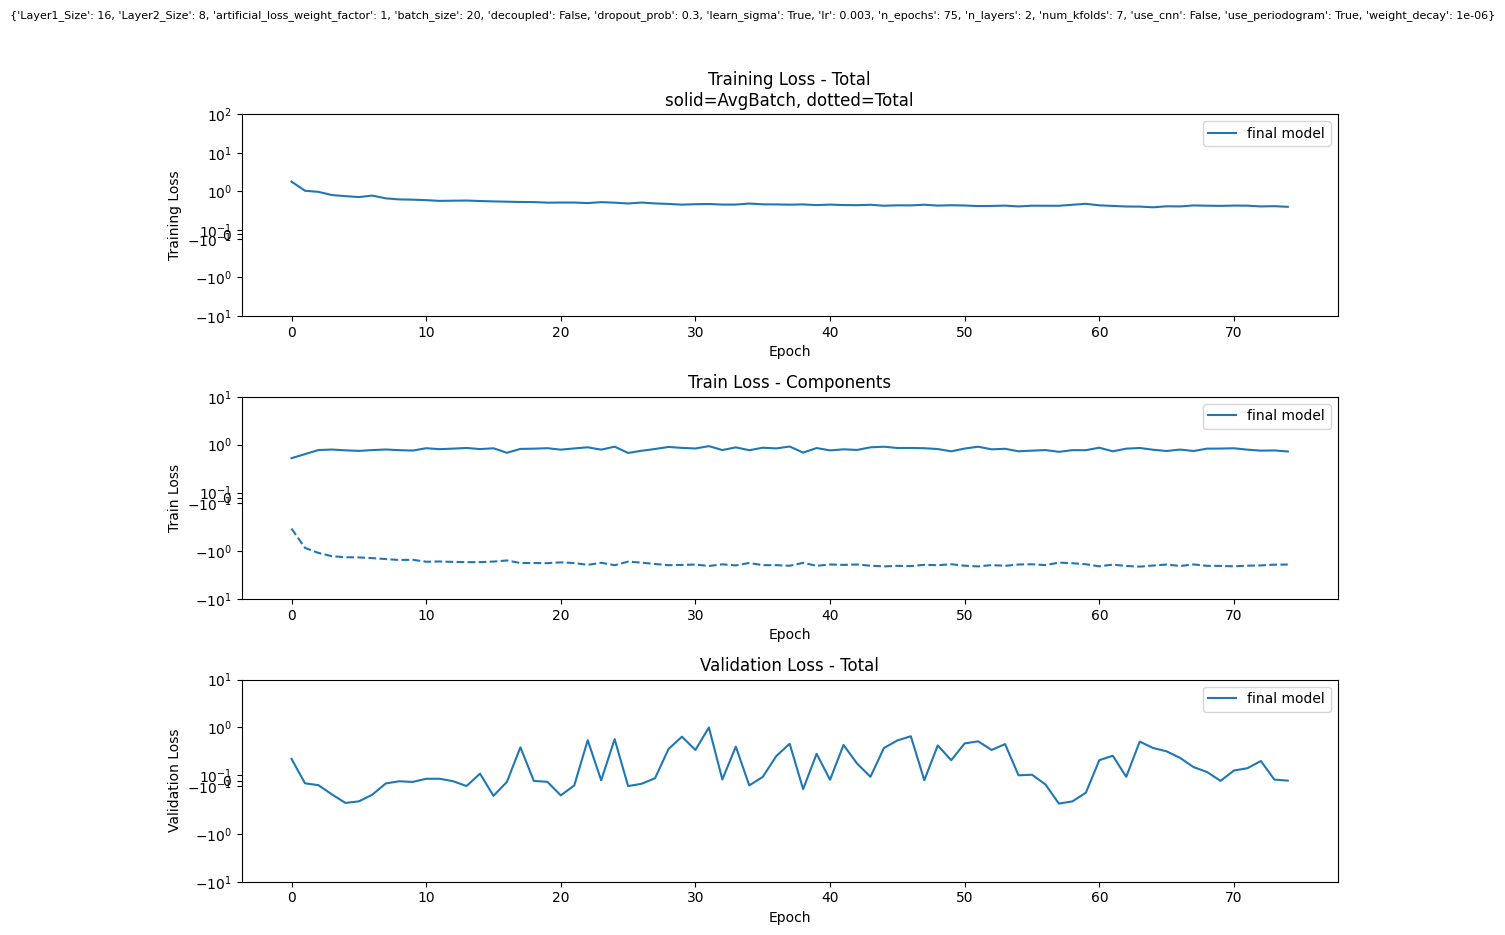

In [23]:
# ============================================================
# VISUALIZE TRAINING PROGRESS
# ============================================================

# Plot training evolution
print("\nGenerating training plots...")
plot_run_log(final_model_log, kfold=False)

single-model


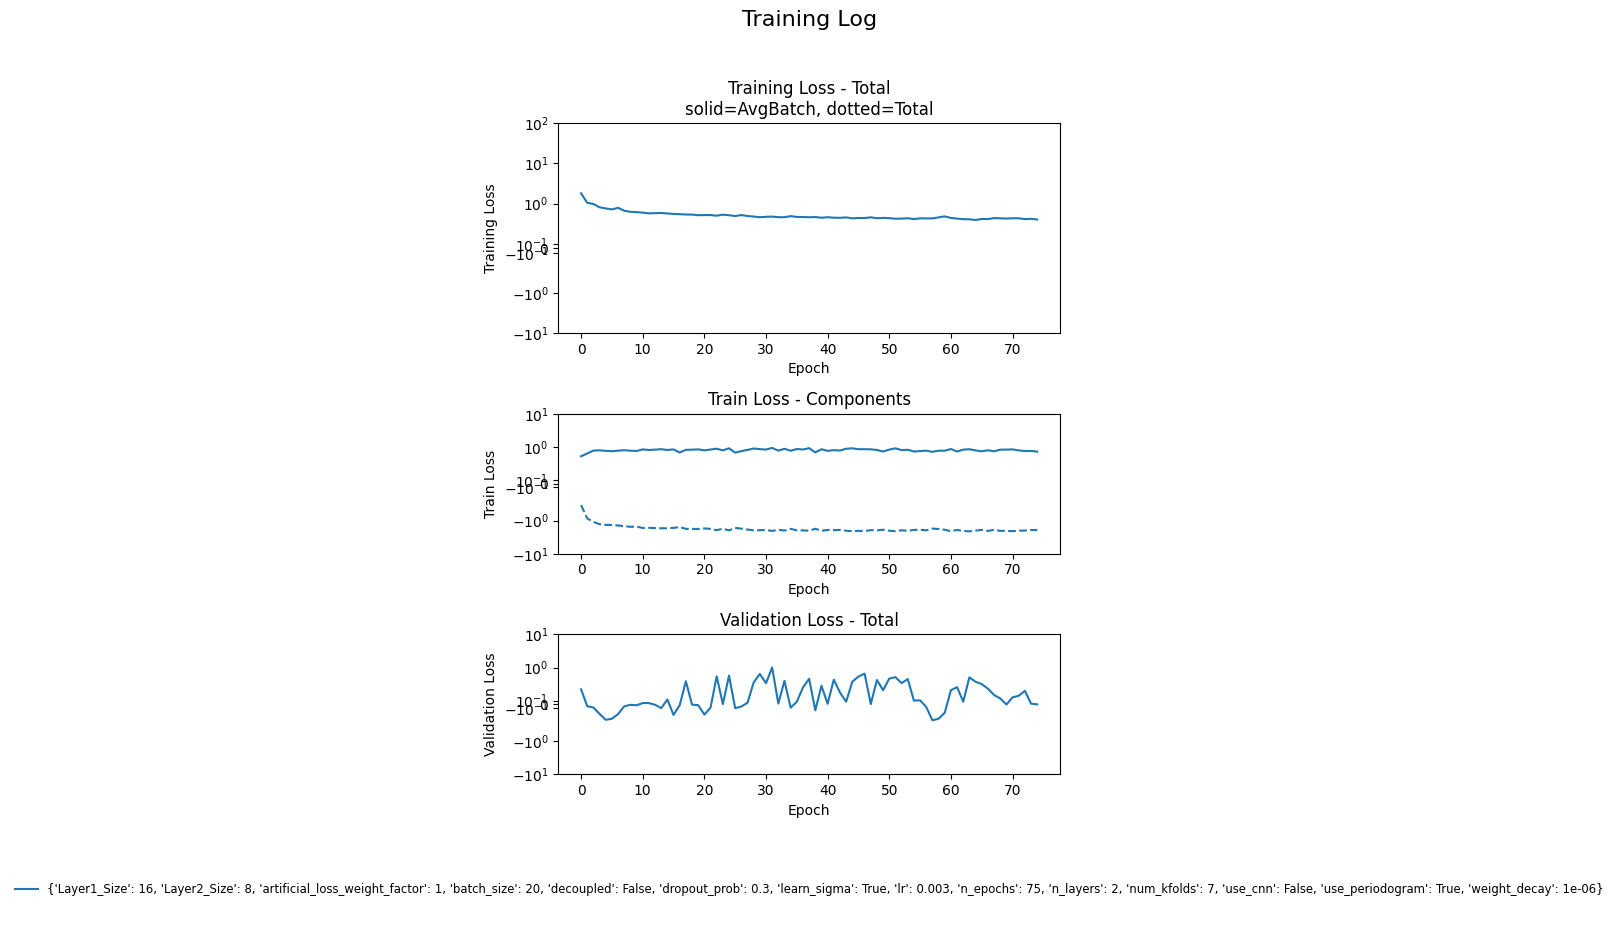

In [25]:
from Kfold_PlottingFcns import plot_trainval_loss_evolution, plot_all_metric_evolution
plot_trainval_loss_evolution(final_model_log)

single_model
Run_id 0
NaNs detected in data, careful.
      train_Loss = nan; epoch = 8
NaNs detected in data, careful.
      mean_batch_loss = nan; epoch = 8
NaNs detected in data, careful.
      train_Loss = nan; epoch = 8
NaNs detected in data, careful.
      valid_Loss = nan; epoch = 8
NaNs detected in data, careful.
      train_errLoss = nan; epoch = 8
NaNs detected in data, careful.
      valid_errLoss = nan; epoch = 8
NaNs detected in data, careful.
      train_sigmaLoss = nan; epoch = 8
NaNs detected in data, careful.
      valid_sigmaLoss = nan; epoch = 8


/Users/howard_willard/opt/anaconda3/envs/star_ML/lib/python3.9/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Kfold_PlottingFcns.py:382: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[metric_id].set_ylim(new_ymin, new_ymax)


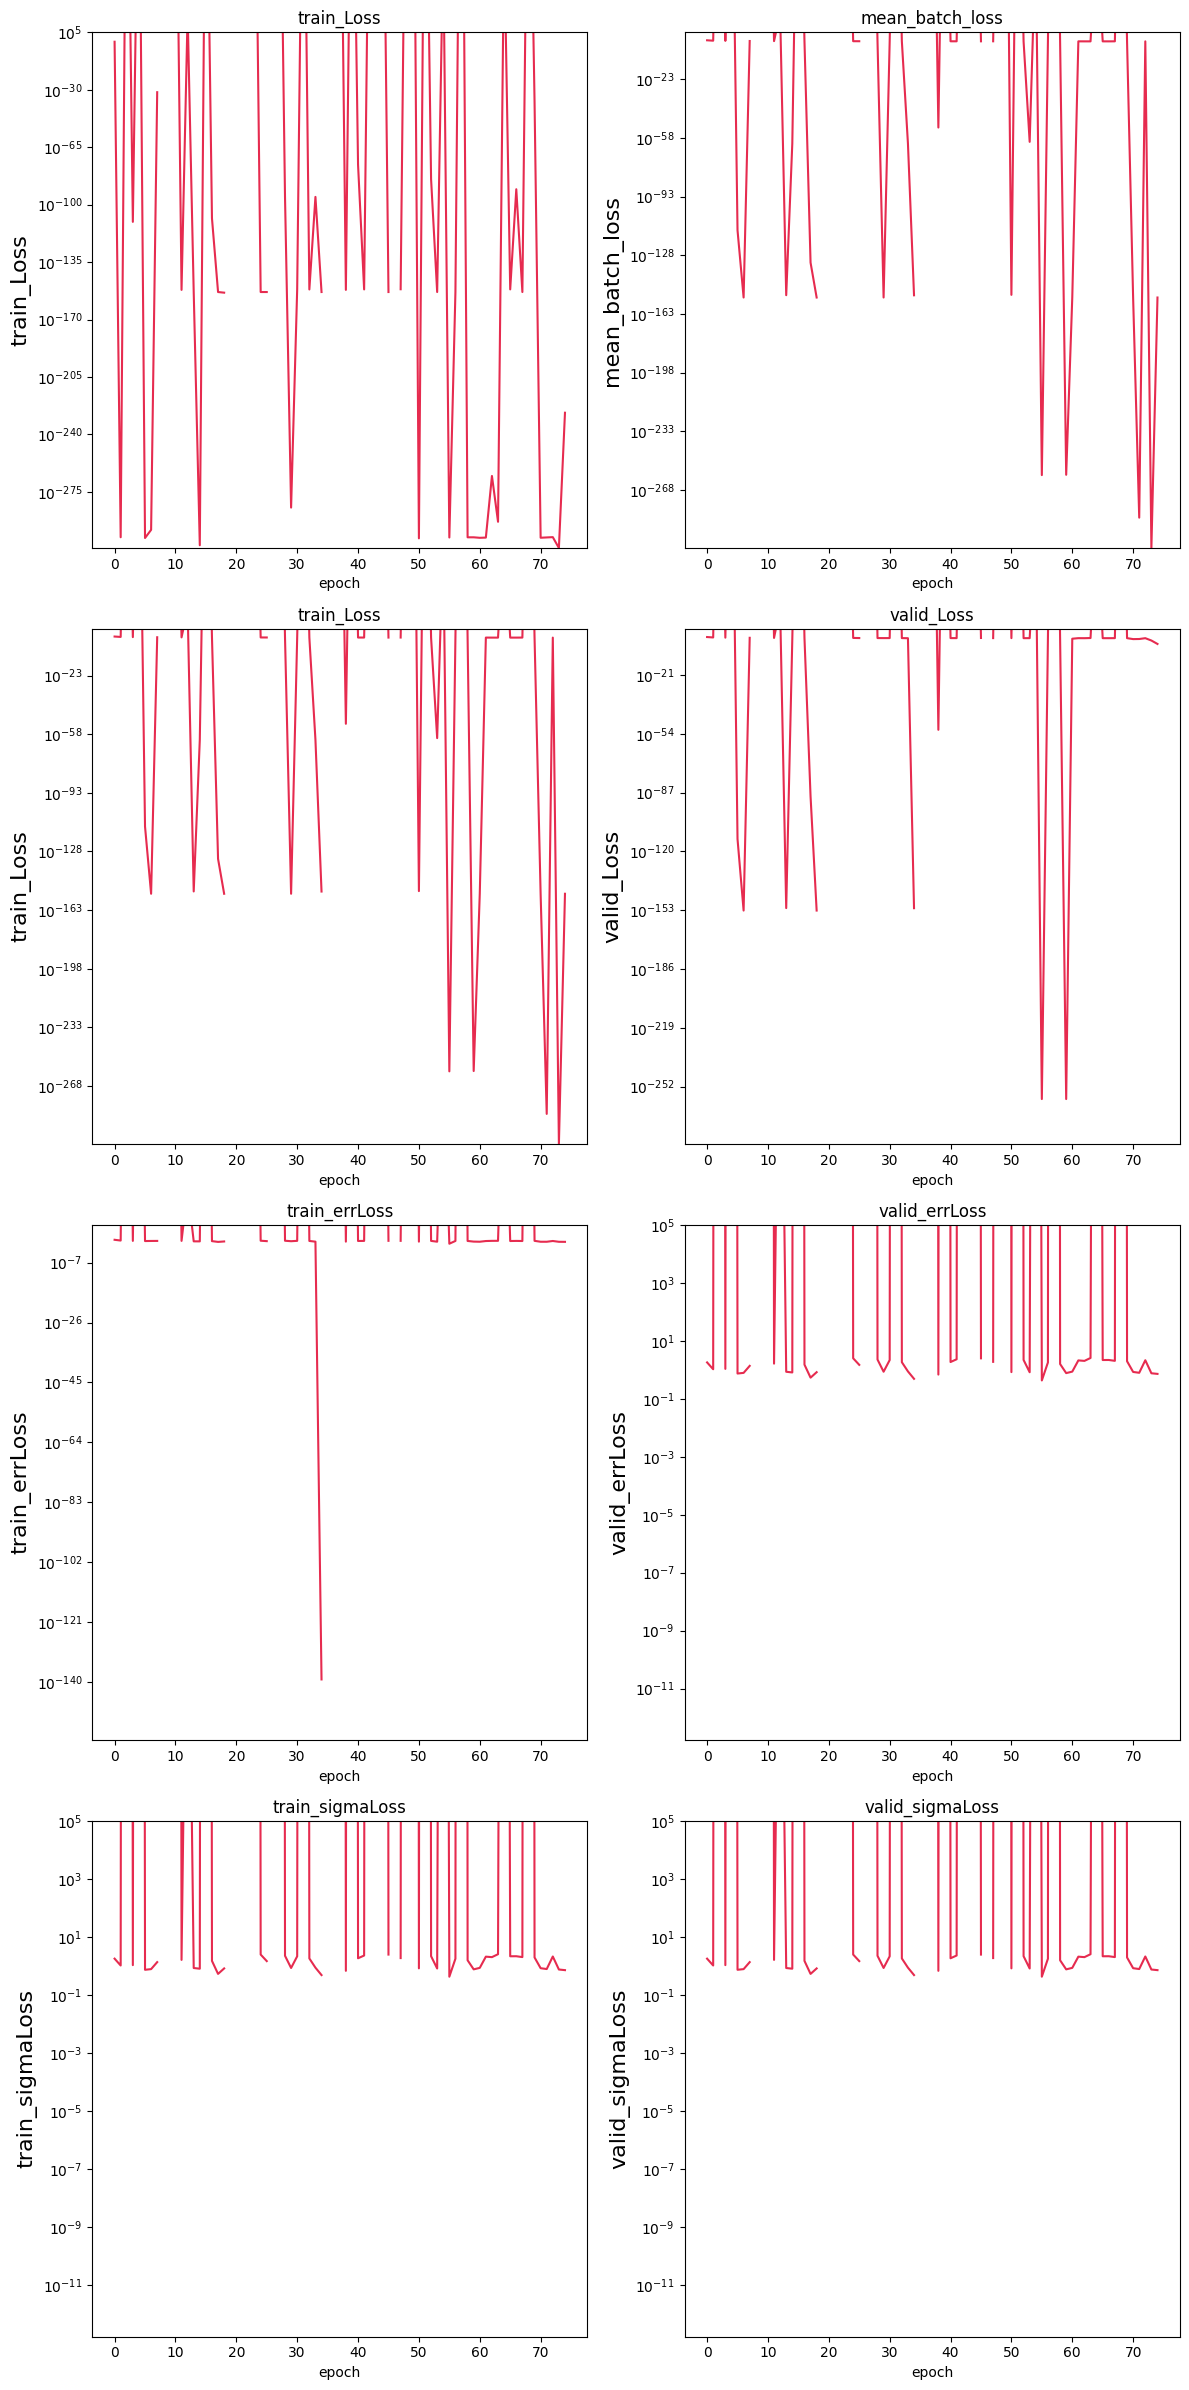

single_model
Run_id 0
      train_RMSE = 0.000000; epoch = 0
      valid_RMSE = 0.000000; epoch = 0
      train_MAE = 0.000000; epoch = 0
      valid_MAE = 0.288704; epoch = 68
      train_median_sigma = 0.329920; epoch = 63
      valid_median_sigma = 0.333864; epoch = 63
      train_mean_sigma = 0.385819; epoch = 70
      valid_mean_sigma = 0.390809; epoch = 70


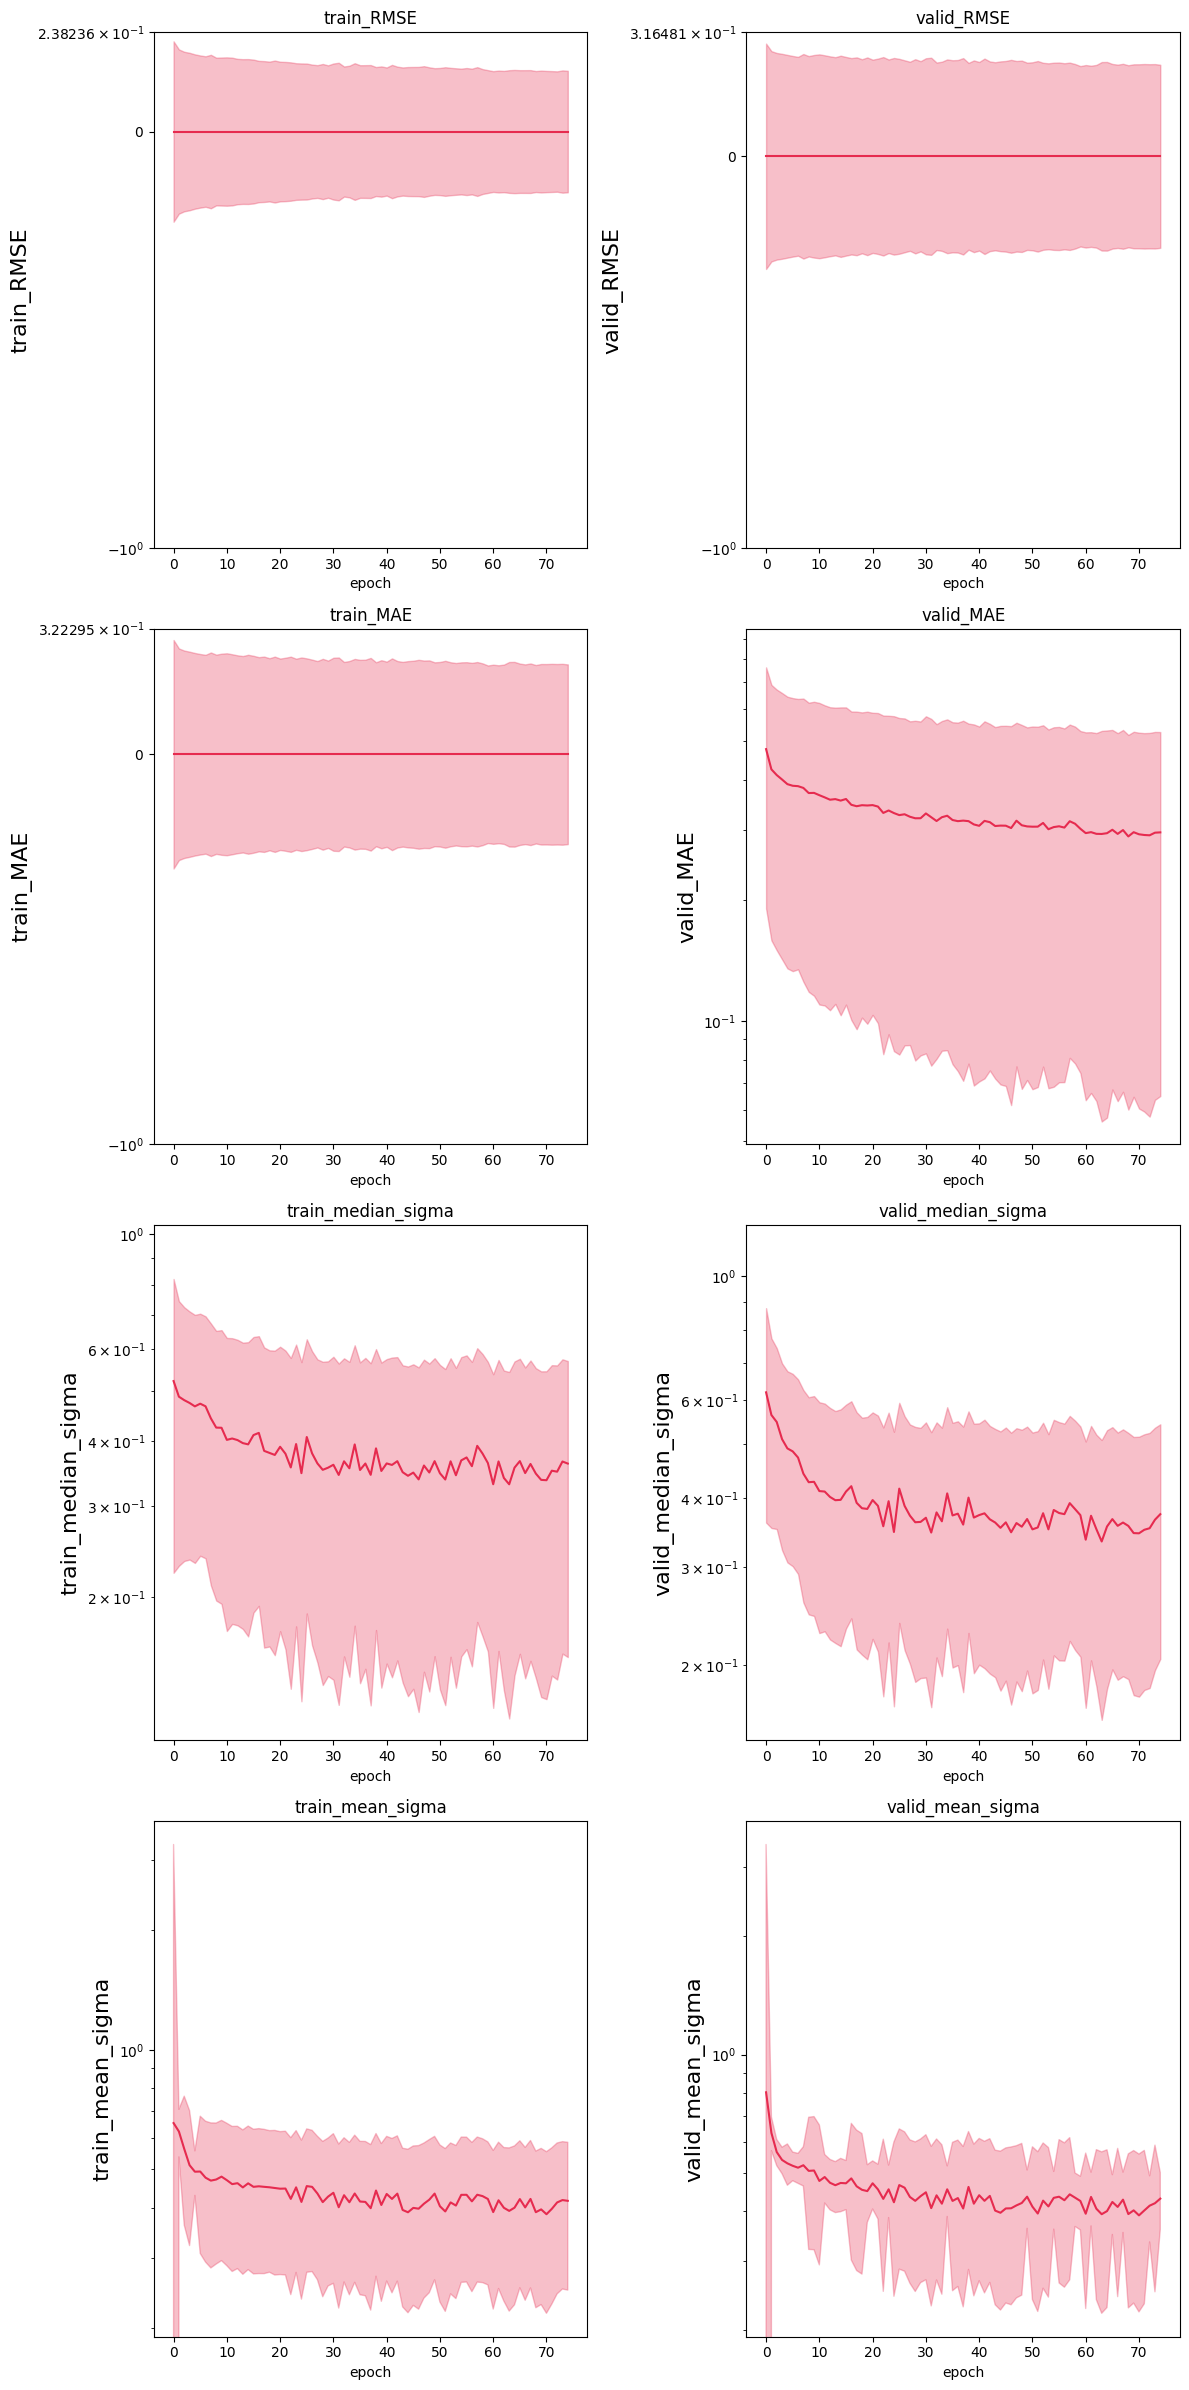

single_model
Run_id 0
NaNs detected in data, careful.
      train_Coverage68 = nan; epoch = 0
      valid_Coverage68 = 0.147337; epoch = 69
      train_Coverage95 = 0.950000; epoch = 0
NaNs detected in data, careful.
      valid_Coverage95 = nan; epoch = 25
      train_CRPS = 0.000000; epoch = 1
NaNs detected in data, careful.
      valid_CRPS = nan; epoch = 27


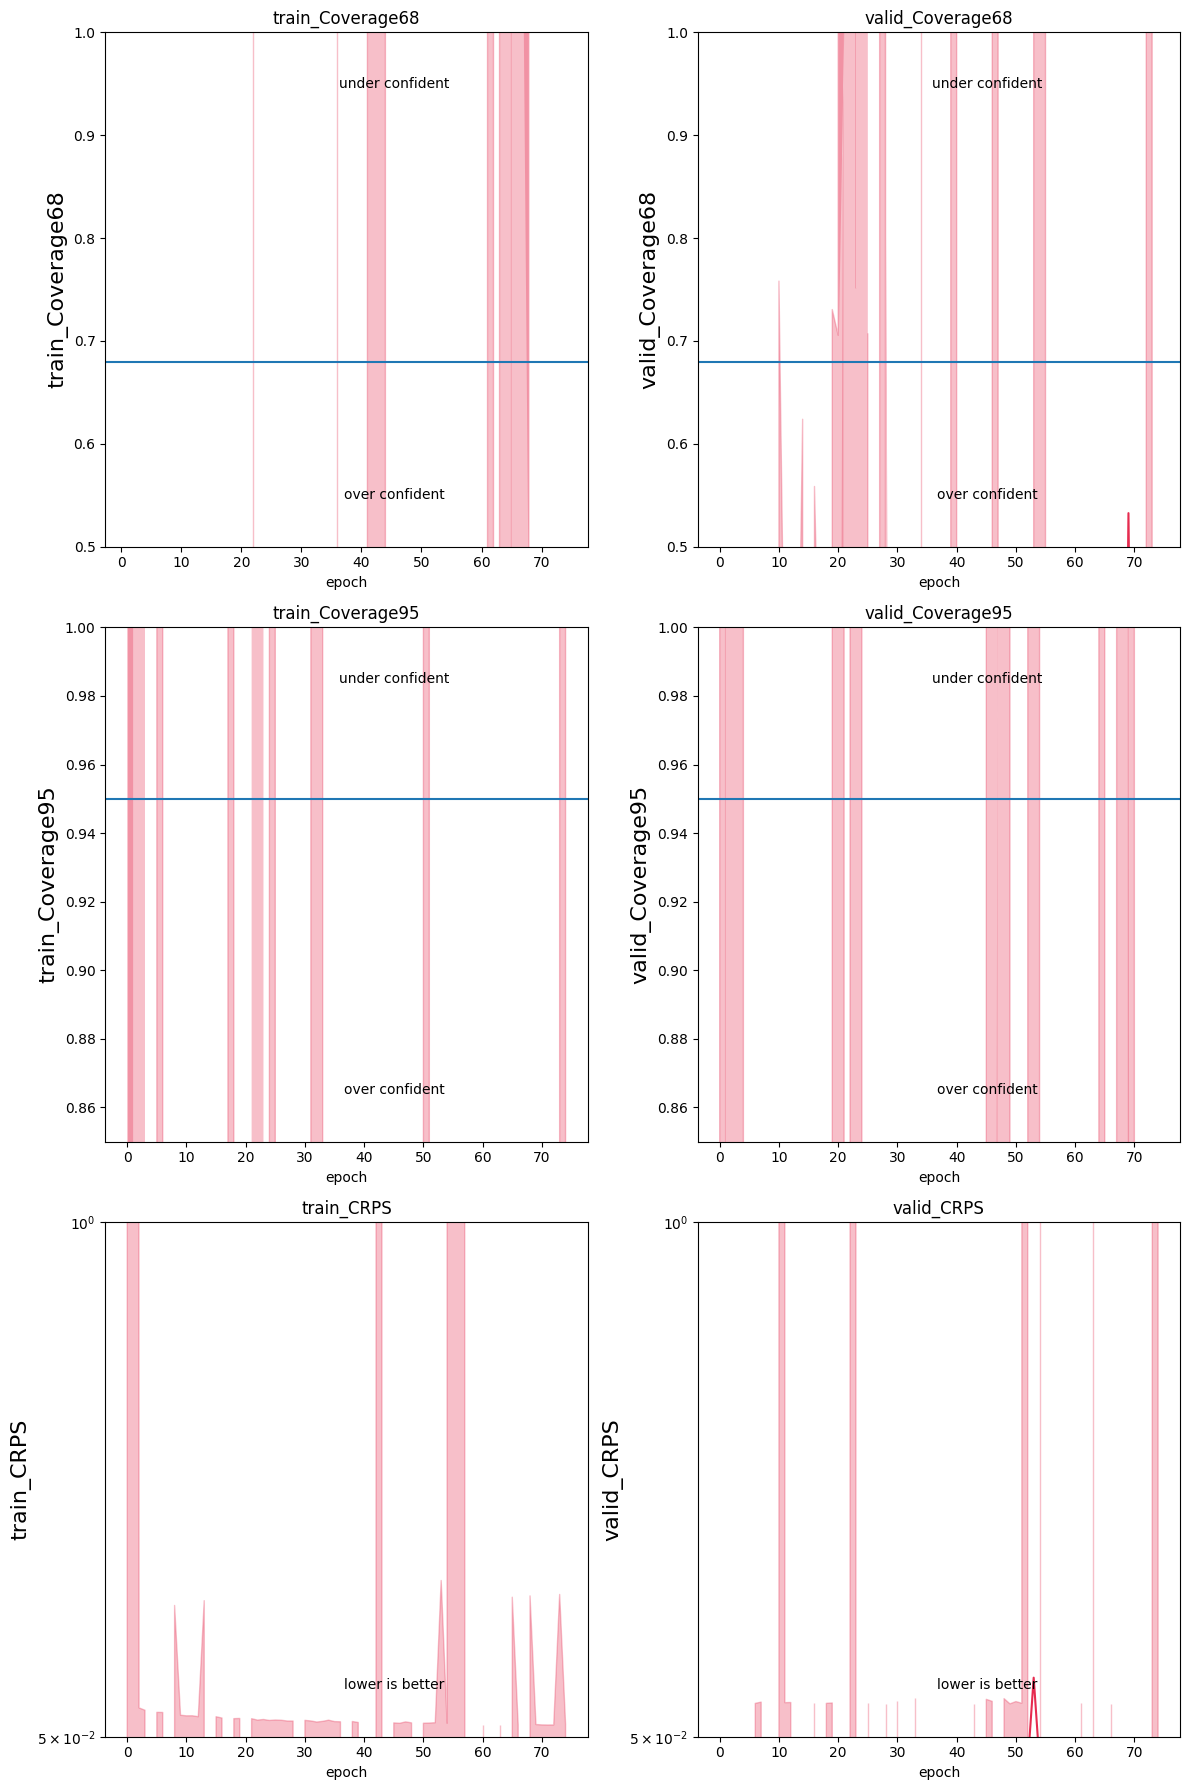

In [27]:
from Kfold_PlottingFcns import plot_all_metric_evolution
plot_all_metric_evolution(final_model_log, k_fold=False)

# Save Final Model

In [22]:
# ============================================================
# SAVE FINAL MODEL
# ============================================================

print("\n" + "="*70)
print("SAVING FINAL MODEL")
print("="*70)

# Prepare model package
model_package = {
    'model_state_dict': final_model_log['model'].state_dict(),
    'hyperparameters': best_params,
    'training_log': final_model_log['log'],
    'best_epoch_from_tuning': best_epoch,
    'composite_score': best_config['composite_score'],
    'scaler': SCALER,
    'y_mean': y_mean,
    'feature_cols': feature_cols,
    'model_architecture': {
        'summary_dim': X_train.shape[1],
        'periodogram_dim': period_train.shape[1],
        'hidden_size': best_params['Layer1_Size'],
        'dropout_prob': best_params['dropout_prob'],
        'use_periodogram': best_params['use_periodogram'],
        'use_cnn': best_params['use_cnn'],
        'learn_sigma': best_params['learn_sigma']
    }
}

# Save to file
output_path = temp_files_path + 'final_model.pt'
torch.save(model_package, output_path)

print(f"\n✅ Model saved successfully!")
print(f"   Location: {output_path}")
print(f"\nModel package contains:")
print(f"   • Trained model weights (state_dict)")
print(f"   • Hyperparameters")
print(f"   • Training log (all metrics)")
print(f"   • Scaler and preprocessing info")
print(f"   • Model architecture details")
print("="*70)


SAVING FINAL MODEL

✅ Model saved successfully!
   Location: /Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/TempFiles/final_model.pt

Model package contains:
   • Trained model weights (state_dict)
   • Hyperparameters
   • Training log (all metrics)
   • Scaler and preprocessing info
   • Model architecture details
